In [1]:
from loadPos import *
from postprocess_pos_data import *
from position_analysis import *
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
from bz_csd import *

# Select file
filename = '/home/isabella/Documents/isabella/jake/recording_data/r1398/2023-08-06/230806_r1398_raw_t-maze_1'  # Replace with the path to your Axona raw file

## LOAD LFP
# Load LFP data and resample to 1250 Hz, then lowpass filter
recording = se.read_axona(f'{filename}.set')
print(recording)

sampling_rate = 1250
recording = spre.resample(recording, sampling_rate)

recording = spre.bandpass_filter(recording, freq_min = 1, freq_max = 300)

AxonaRecordingExtractor: 64 channels - 1 segments - 48.0kHz - 600.062s
  file_path: /home/isabella/Documents/isabella/jake/recording_data/r1398/2023-08-06/230806_r1398_raw_t-maze_1.set


In [2]:
## LOAD POSITION

# Set position constants
max_speed = 5  # m/s
smoothing_window_size = 3  # Choose an appropriate window size for smoothing

# Read and unpack the file
posdata = loadPos(filename)

# Post-process the position data
xy_pos, led_pos, led_pix, speed, direction, direction_disp = process_position_data(posdata, max_speed, smoothing_window_size)

# Calculate choice performance and add to dataframe
sectors = assign_sectors(xy_pos.T)
performance = calculate_choices(xy_pos, sectors)

performance

Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1398/2023-08-06/230806_r1398_raw_t-maze_1.pos
65 LED swaps detected and fixed


/data/isabella/klusta_testdata/spikeinterface/postprocess_pos_data.py:221: RuntimeWarning: invalid value encountered in remainder
  dir_disp = np.mod(np.arctan2(-pos.iloc[1, 1:].values + pos.iloc[1, :-1].values, pos.iloc[0, 1:].values - pos.iloc[0, :-1].values) * 180 / np.pi, 360)


Sectors assigned incorrectly, please check


{'total_choices': 24,
 'total_left_choices': 14,
 'total_right_choices': 10,
 'total_correct_choices': 19,
 'p_correct': 0.7916666666666666,
 'p_left_choices': 0.5833333333333334}

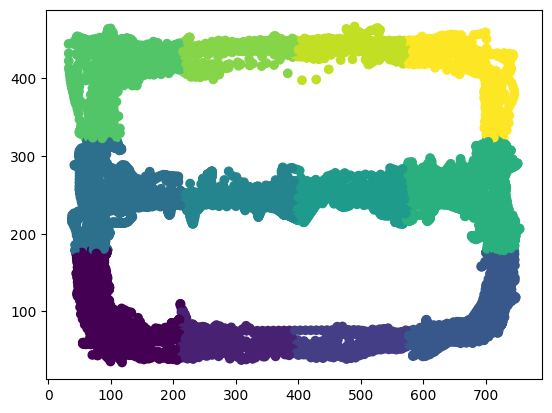

In [6]:
import matplotlib.pyplot as plt

xy_interpolated = xy_pos#.interpolate(method = 'linear', axis = 1)

plt.scatter(xy_interpolated.loc['X'], xy_interpolated.loc['Y'], c = assign_sectors(xy_interpolated.T))

In [117]:
# SELECT POSITION ROIs
# Calculate CSD only when rat is in a particular sector
desired_sector = 11

# Channels to calculate CSD for
channels = range(24,37)

# Rearrange the xy_pos dataframe
xy_pos = xy_pos.T
xy_pos = xy_pos.astype(float)

# Find continuous stretches of the desired sector
continuous_stretches = []
current_stretch = []

for i, sector in enumerate(sectors):
    if sector == desired_sector:
        current_stretch.append(i)
    else:
        if current_stretch:
            continuous_stretches.append((current_stretch[0], current_stretch[-1]))
            current_stretch = []

# Handle the case where the last sector is the desired sector
if current_stretch:
    continuous_stretches.append((current_stretch[0], current_stretch[-1]))

# Convert sample indices to time (seconds)
epochs_df = pd.DataFrame(continuous_stretches, columns=['Start_Sample', 'End_Sample'])
epochs_df['Start_Time'] = epochs_df['Start_Sample'] / 50  # Convert samples to seconds
epochs_df['End_Time'] = epochs_df['End_Sample'] / 50       # Convert samples to seconds

# Retain only the time columns for the final output
epochs_df = epochs_df[['Start_Time', 'End_Time']]

# Collect LFP for each dwell time and store in a list of dicts
sampling_rate = 1250

lfp_epochs = []

for index, row in epochs_df.iterrows():
    start_time = row['Start_Time']
    end_time = row['End_Time']

    lfp_data = recording.get_traces(start_frame=int(start_time * sampling_rate), 
                                    end_frame=int(end_time * sampling_rate))
    lfp_timestamps = recording.get_times()[int(start_time * sampling_rate):int(end_time * sampling_rate)]
    
    lfp = {
        'data': lfp_data,
        'timestamps': lfp_timestamps,
        'samplingRate': sampling_rate
    }
    # csd_result = bz_csd(lfp, spat_sm=5, temp_sm=7, plotLFP=False, plotCSD=False, channels = channels)
    
    lfp_epochs.append(lfp)

len(lfp_epochs)


14

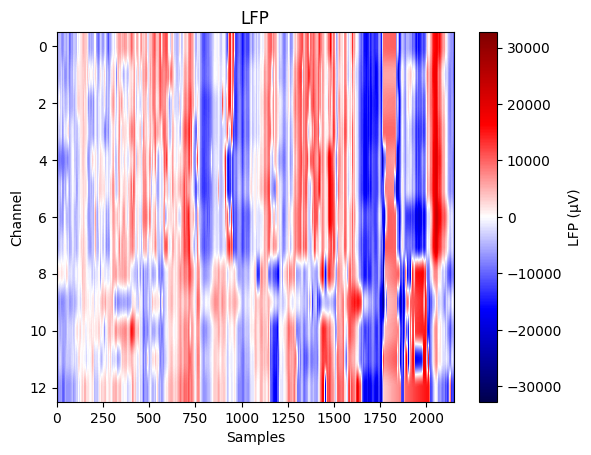

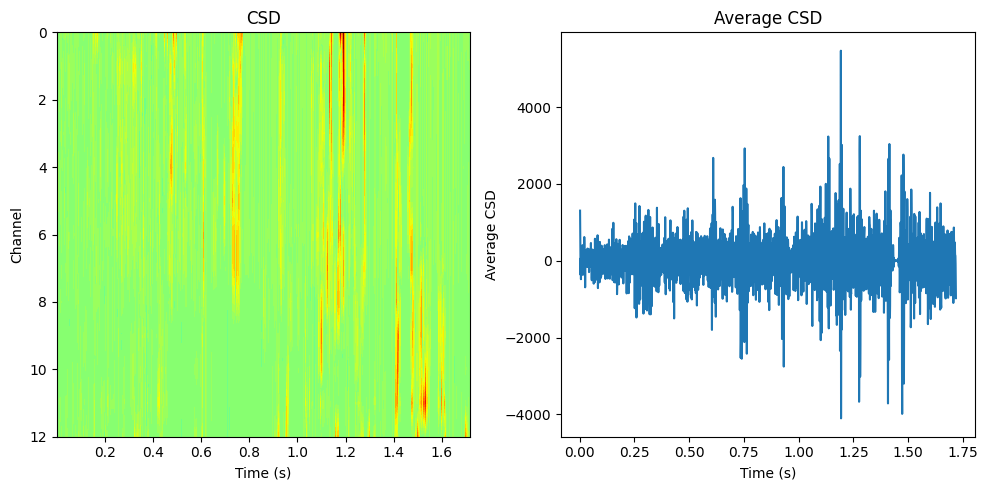

In [118]:
# Average across dwell instances and plot
all_data = [epoch['data'] for epoch in lfp_epochs]

# Find the length of the longest epoch
max_length = max(epoch['data'].shape[0] for epoch in lfp_epochs)

# Initialise an array full of NaNs (size: n_epochs, n_channels, max_length)
aligned_data = np.full((len(lfp_epochs), all_data[0].shape[1], max_length), np.nan)

for i, data in enumerate(all_data):
    aligned_data[i, :, :data.shape[0]] = data.T

avg_data = np.nanmean(aligned_data, axis=0)

avg_lfp = {
    'data': avg_data.T,
    'timestamps': np.linspace(0, (max_length-1)/1250, max_length),  # Assuming a constant sampling rate
    'samplingRate': 1250,
}

csd_result = bz_csd(avg_lfp, spat_sm=5, temp_sm=7, plotLFP=True, plotCSD=True, channels = channels)

array([ 1174.6 ,  1490.72,   452.6 , ..., -1736.  , -3024.  , -5803.  ])